In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 40000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-06-23_19-16_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])

In [4]:
df = df.loc['20190101':]

In [5]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [6]:
allocs

ES       0.5
NQ       0.5
total    1.0
dtype: float64

In [7]:
df.groupby('contract').realizedPNL.sum()

contract
ES     9645.7
NQ    11685.4
Name: realizedPNL, dtype: float64

In [8]:
df.realizedPNL.sum()

21331.1

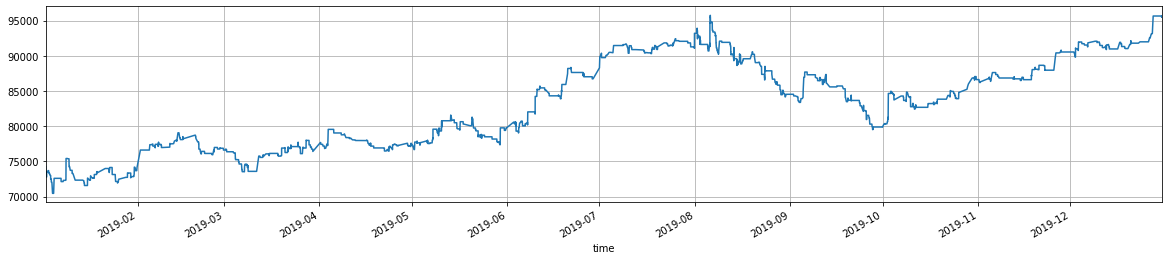

In [9]:
df.cash.plot(figsize=(20,4), grid=True);

In [10]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [11]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     257
 NQ    1326
 Name: action, dtype: int64, 1583)

In [12]:
# trades per day
days = len(by_contract.resample('D').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.707989
 NQ    3.652893
 Name: action, dtype: float64, 4.360881542699724)

In [13]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     539.7
NQ    2784.6
Name: commission, dtype: float64

In [14]:
df.commission.sum()

3324.300000000001

In [15]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.41,17.63,381.17,-232.14,1.64,19.32,663.0
ES,0.41,74.77,887.07,-491.70,1.80,73.60,129.0
total,0.41,26.93,464.18,-274.20,1.69,28.54,792.0


In [16]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [17]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

contract,ES,NQ,total
contract,,,
ES,1.000000,0.086777,0.735329
NQ,0.086777,1.000000,0.738667
total,0.735329,0.738667,1.000000


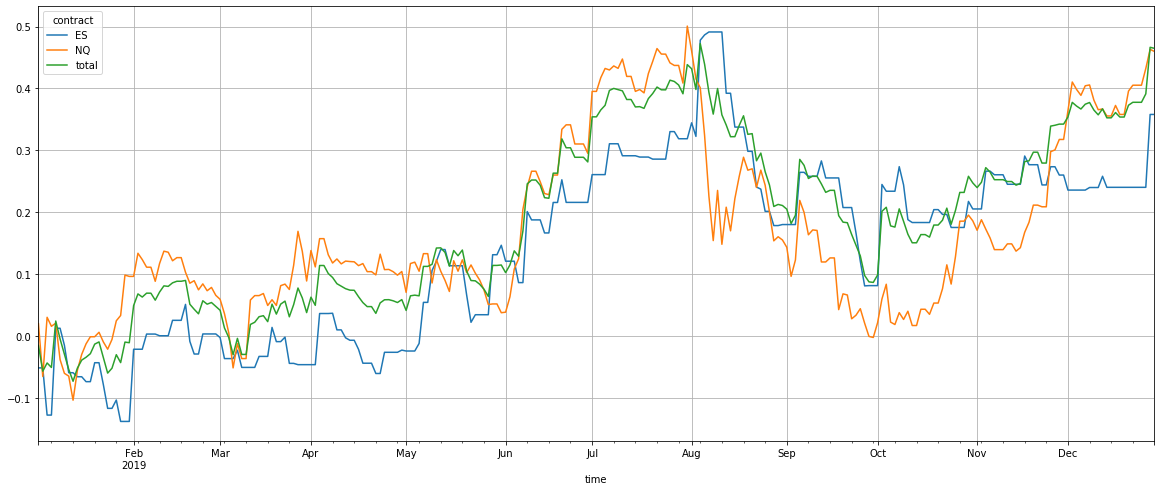

In [18]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

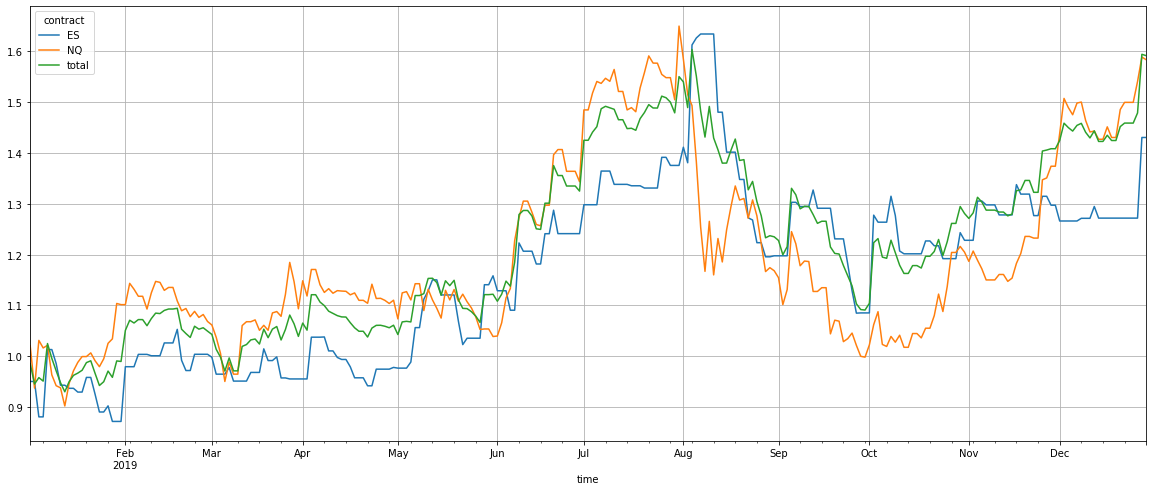

In [19]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [20]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,NQ,total
Annual return,0.416823,0.564048,0.571748
Cumulative returns,0.430602,0.583602,0.591615
Annual volatility,0.503329,0.494998,0.368927
Sharpe ratio,0.932293,1.148447,1.406414
Calmar ratio,1.239931,1.428154,1.788130
Stability,0.614524,0.253570,0.586878
Max drawdown,-0.336167,-0.394949,-0.319746
Omega ratio,1.284373,1.234111,1.310293
Sortino ratio,1.842009,1.857601,2.675480
Skew,2.285298,0.479318,1.422870


In [21]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,ES,NQ,total
time,,,
2019-01-31,-12.83,10.16,-1.02
2019-02-28,15.16,-3.01,6.02
2019-03-31,-4.84,2.35,-0.98
2019-04-30,2.38,1.54,2.12
2019-05-31,18.44,-6.44,5.74
2019-06-30,7.16,29.33,18.10
2019-07-31,10.82,22.79,17.00
2019-08-31,-12.93,-29.19,-20.33
2019-09-30,-9.39,-14.56,-11.67


In [22]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES       43.0
NQ       58.0
total    59.0
dtype: float64

In [23]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:46:00,ES,BUY,2891.75,3545.8
2019-08-05 21:20:00,ES,BUY,2841.75,3358.3
2019-01-08 16:48:00,ES,SELL,2551.50,3008.3
2019-06-10 03:00:00,ES,SELL,2881.00,2508.3
2019-12-27 21:50:00,ES,SELL,3236.75,2495.8
...,...,...,...,...
2019-01-02 03:36:00,ES,SELL,2490.00,-991.7
2019-10-10 02:00:00,ES,BUY,2906.50,-1091.7
2019-08-13 17:17:00,ES,SELL,2921.50,-1154.2


In [24]:
daily.sort_values('total', ascending=False)

contract,ES,NQ,total
time,,,
2019-10-02,0.177290,0.03895,0.108120
2019-09-05,0.087915,0.10087,0.094392
2019-06-10,0.121455,0.03662,0.079038
2019-12-27,0.124790,0.03133,0.078060
2019-01-08,0.150415,0.00508,0.077747
...,...,...,...
2019-09-18,0.000000,-0.08005,-0.040025
2019-01-03,0.000000,-0.08155,-0.040775
2019-08-12,0.000000,-0.08326,-0.041630
